# COE347 HW4
**Author: Alex Choi** <br>
*Date: 2025-02-17*

---
## Question 1
The Forward Difference Approximation is:
$$ u(x+h) = u(x) + h u'(x) + \frac{h^2}{2!} u''(x) + \frac{h^3}{3!} u'''(x) + \frac{h^4}{4!} u^{(4)}(x) + \dots $$
The Backward Differene Approximation is:
$$ u(x-h) = u(x) - h u'(x) + \frac{h^2}{2!} u''(x) - \frac{h^3}{3!} u'''(x) + \frac{h^4}{4!} u^{(4)}(x) + \dots $$
Switch to index notation and add $ u(x+h) $ and $ u(x-h) $
$$
u_{i+1} + u_{i-1} = 2 u_i + h^2 u''_i + 2\frac{h^4}{4!} u^{(4)}(x) + h.o.t.
$$
Now, rearrange:

$$
h^2 u''_i = u_{i+1} - 2u_i + u_{i-1} - 2\frac{h^4}{4!} u^{(4)}(x_i) + h.o.t.
$$

Here, we can clearly see that:
$$
C = -2\frac{1}{4!} = -\frac{1}{12}
$$

In [397]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # for tabular displays
from scipy.linalg import solve, solve_banded # for efficeint solver of tridiagonal system.
from scipy.interpolate import PchipInterpolator # need for 3rd order interpolation of exact solution
from scipy.stats import linregress
from pprint import pprint
from IPython.display import display, Markdown, HTML


# we will go ahead and define a helper function to read in exact solution file for latr use
def read_dat_file(filename = str) -> tuple:
    # Load the data from the file
    data = np.loadtxt(filename)

    # Extract x and y values (assuming two columns)
    return np.array(data[:, 0]), np.array(data[:, 1])

# let's first define our ODE, or a given function
def ode_eq1(x):
    """
    Returns f(x) = (4π)^2 cos(4πx)
    """
    return 16 * (np.pi ** 2) * np.cos(4 * np.pi * x)
    

---
## Question 2
Here, we implement a numerical solution to the given boundary value problem using the second-order finite difference formula (FDF) for approximating $u''(x)$. We discretize the domain, construct a system of linear equations, and solve for $u_i$ at interior points. The numerical solution is obtained for $N = 10$ and can be compared against the exact solution provided in the dataset.

We first have to attain a matrix-vector form of our linear systems of equations for all values of $u_i$

Given our ODE:
$$
u''(x) = f(x) = (4\pi)^2 \cos(4\pi x) = 16\pi^2 \cos(4\pi x) \quad \text{(1)}
$$

And Given our Second-Order Finite Difference Approximation:
$$
u''(x_i) h^2 = u_{i+1} - 2u_i + u_{i-1} + \mathcal{O}(h^2) \quad \text{(2)}
$$

Equating (1) and (2):

$$
h^2 16\pi^2 \cos(4\pi x_i) = u_{i+1} - 2u_i + u_{i-1} \quad \text{(3)}
$$

Converting to a System of Equations:

$$
h^2
\begin{bmatrix}
f_1 - u(0) \\
f_2 \\
\vdots \\
f_N - u(1)
\end{bmatrix}
=
\begin{bmatrix}
-2 & 1  & 0  & \dots  & 0  \\
1  & -2 & 1  & \dots  & 0  \\
0  & 1  & -2 & \dots  & 0  \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0  & 0  & 0  & 1  & -2
\end{bmatrix}
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_N
\end{bmatrix}
$$

where:
- The **main diagonal** is filled with **-2**.
- The **superdiagonal** and **subdiagonal** are filled with **1**.
- The right-hand side includes **boundary conditions** at $x = 0$ and $x = 1$.

This forms a **tridiagonal system** that we can solve numerically.

### Construct the BVP solver

In [398]:
# now formulate the BVP solver for our ODE:
def solve_bvp(ode, x_range: list, u_i: float, u_f: float, N: int):
    """
    Solves a boundary value problem (BVP) using the second-order finite difference method (FDF).

    Parameters:
        ode (function): The function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        u0 (float or int): The boundary condition at x = 0 (i.e., u(0) = u0).
        uf (float or int): The boundary condition at x = 1 (i.e., u(1) = uf).
        N (int): The number of interior grid points.

    Returns:
        numpy.ndarray: The numerical solution u at the interior grid points plus boundary conditions.
        numpy.ndarray: The corresponding x values at the interior points.

    Notes:
        - The step size h is computed as h = 1 / (N + 1).
        - The finite difference approximation is used to construct a system of linear equations.
        - The system is solved to obtain the numerical solution for u(x) at interior points.
    """
    # Extract final and initial x values
    x_i, x_f = x_range[0], x_range[1]
    # define step-size h:
    h = (x_f - x_i) / (N + 1)
    
    # construct our tri-diagonal matrix system
    main_diag = -2 * np.ones(N, dtype = float) # main diagonal is -2s.
    other_diag = np.ones(N-1, dtype = float) # super and sub diagonal are all 1s. Note: subtract one row.
    # "stack" the diagonals in the format expected by `solve_banded`. ab has to be banded, not normal numpy matrix
    tri_diagonal = np.zeros((3, N))
    tri_diagonal[0, 1:] = other_diag  # Superdiagonal (shifted right)
    tri_diagonal[1, :] = main_diag    # Main diagonal
    tri_diagonal[2, :-1] = other_diag # Subdiagonal (shifted left)

    # define N number of interior points, x_i for i = 1,...,N
    x_interior = np.linspace(start = x_i + h, stop = x_f - h, num = N, dtype = float)

    # evaluate values of ODE, f(x_i), at different interior points
    f = ode(x_interior) * (h ** 2) # multiply by h^2
    # Apply boundary conditions to the right-hand side vector
    f[0] -= u_i # apply boundary condition u(0) = u_0
    f[-1] -= u_f # apply boundary condition u(f) = u_N+1

    # solve the system of equations
    u_interior = solve_banded(l_and_u = (1, 1), ab = tri_diagonal, b = f)
    
    # finally, form full x and u by including boundary conditions and interior values
    # create empty array to store interior plus two end points
    x = np.empty(N + 2)
    u = np.empty(N + 2)
    # assign boundary conditions
    x[0], x[-1] = x_i, x_f # starting and ending x values
    u[0], u[-1] = u_i, u_f # starting and ending u values
    # Assign interior values
    x[1:-1] = x_interior
    u[1:-1] = u_interior

    return x, u

### Plot of Numerical against Exact Solution for $N = 10^4$.

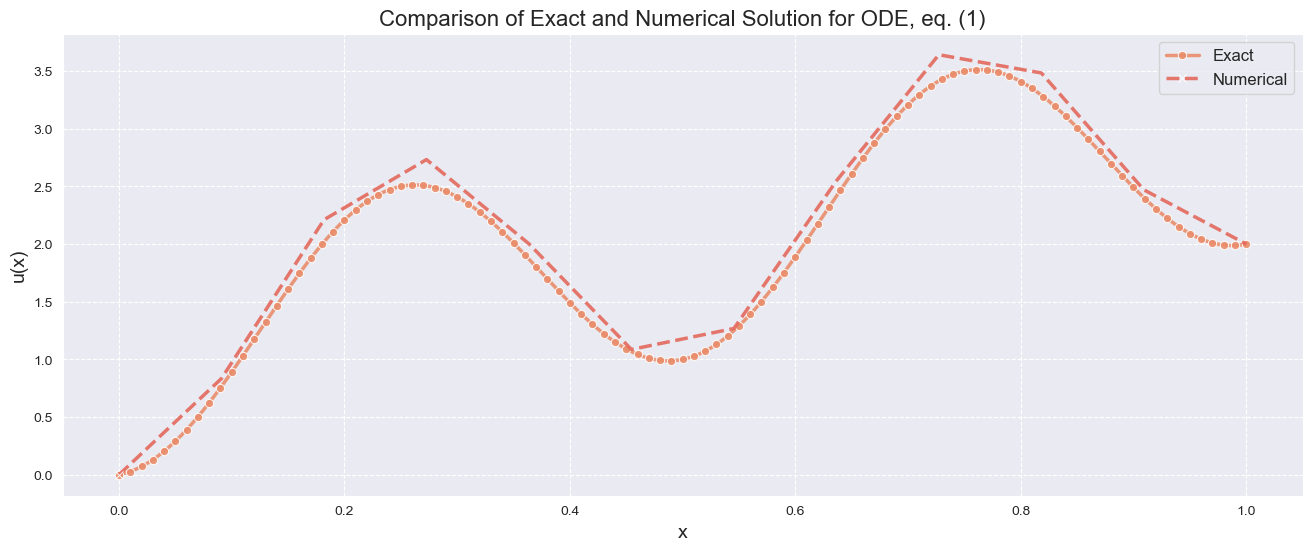

In [399]:
sns.set_style("darkgrid")
sns.set_palette("flare")

# problem conditions
N = 10
x_span = [0,1]
u0 = 0 
u1 = 2

# load in the exact values
exact_x, exact_u = read_dat_file("solutionA_N10000.dat")
# comput data points
numerical_x_Ne4, numerical_u_Ne4 = solve_bvp(ode_eq1, x_span, u0, u1, N)

# Plot the data
plt.figure(figsize=(16, 6))
# Exact solution
sns.lineplot(x=exact_x, y=exact_u, marker='o', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=100, label="Exact")
# Numerical solution
sns.lineplot(x=numerical_x_Ne4, y=numerical_u_Ne4, marker='x', markersize=6, linestyle='--', linewidth=2.5, alpha=0.9, markevery=100, label="Numerical")

# xlabel, ylabel, title, etc.
plt.xlabel("x", fontsize=14), plt.ylabel("u(x)", fontsize=14), plt.title("Comparison of Exact and Numerical Solution for ODE, eq. (1)", fontsize=16)
plt.legend(fontsize=12), plt.grid(True, linestyle="--", alpha=1)

# Show plot
plt.show()


### Solution for $ N = 10 $ and Tabular Format
We will compute our numerical solution for the case $N = 10$ and print the results in a tabular format.

In [400]:
N = 10
# obtain numerical solution for N = 10
numeric_x_N10, numeric_u_N10 = solve_bvp(ode_eq1, x_span, u_i=u0, u_f=u1, N=N)
# make a pandas Dataframe for tabular format
df_N10 = pd.DataFrame(
    data={
        '$x_i$': numeric_x_N10,  # LaTeX notation for x_i
        '$u_i$': numeric_u_N10   # LaTeX notation for u_i
    }, 
    index=pd.Index(range(N+2), name='$N$')  # Ensure index is also formatted in LaTeX
)

# Display DataFrame with LaTeX formatting in HTML
display(HTML(df_N10.to_html(escape=False)))


,$x_i$,$u_i$
$N$,,
0,0.000000,0.000000
1,0.090909,0.834354
2,0.181818,2.210854
3,0.272727,2.732715
4,0.363636,2.002368
5,0.454545,1.086290
6,0.545455,1.268108
7,0.636364,2.547822
8,0.727273,3.641805


---
## Question 3
### Error Analysis for various values of $N$

We will compute the numerical solution for different values of $N$ and compare it against the exact solution ($N=10^4$). The errors are defined as:

$$
E = \left[ \sum_{i=1}^{N} (u_i - \tilde{u}_i)^2 \right]^{\frac{1}{2}}
$$

$$
e = \frac{1}{N} \left[ \sum_{i=1}^{N} (u_i - \tilde{u}_i)^2 \right]^{\frac{1}{2}}
$$

where:
- $u_i$ is the numerical solution
- $\tilde{u}_i$ is the interpolated exact solution at $x_i$
- $h = (N+1)^{-1}$ is the step size.

We will compute the errors for:

$$
N = \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}
$$

and fit a function of the form:

$$
E = C h^{\alpha}
$$

#### Interpolation of the Exact Solution

Since the exact solution is only available at a fine grid ($N=10^4$), we must interpolate it to match the grid points of the numerical solutions ($N=5,10,20,\dots,1280$). 

To ensure accurate error calculations:
- The exact solution $\tilde{u}_i$ should be evaluated **at the same $x_i$ points** as the numerical solution.
- We use **shape-preserving interpolation** (`PchipInterpolator`) to minimize oscillations and avoid large interpolation errors.
- The interpolation error **must be smaller** than the numerical error we are analyzing.



In [401]:
# store different number of steps
steps = np.array([5, 10, 20, 40, 80, 160, 320, 640, 1280], dtype = int)
# we will first compute different step-sizes h and store it
step_sizes = 1 / (steps + 1)

# Solve BVP for multiple step values and store results in lists
numeric_solutions = [solve_bvp(ode_eq1, x_span, u0, u1, N) for N in steps]
# Extract x and u values for each N
numeric_Xs = [np.array(sol[0], dtype=float) for sol in numeric_solutions]  # Extract all x values
numeric_Us = [np.array(sol[1], dtype=float) for sol in numeric_solutions]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x, exact_u)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us = [interpolator(Xs) for Xs in numeric_Xs]

#### Log-log plot that shows $E$ and $e$ versus $h^{-1}$

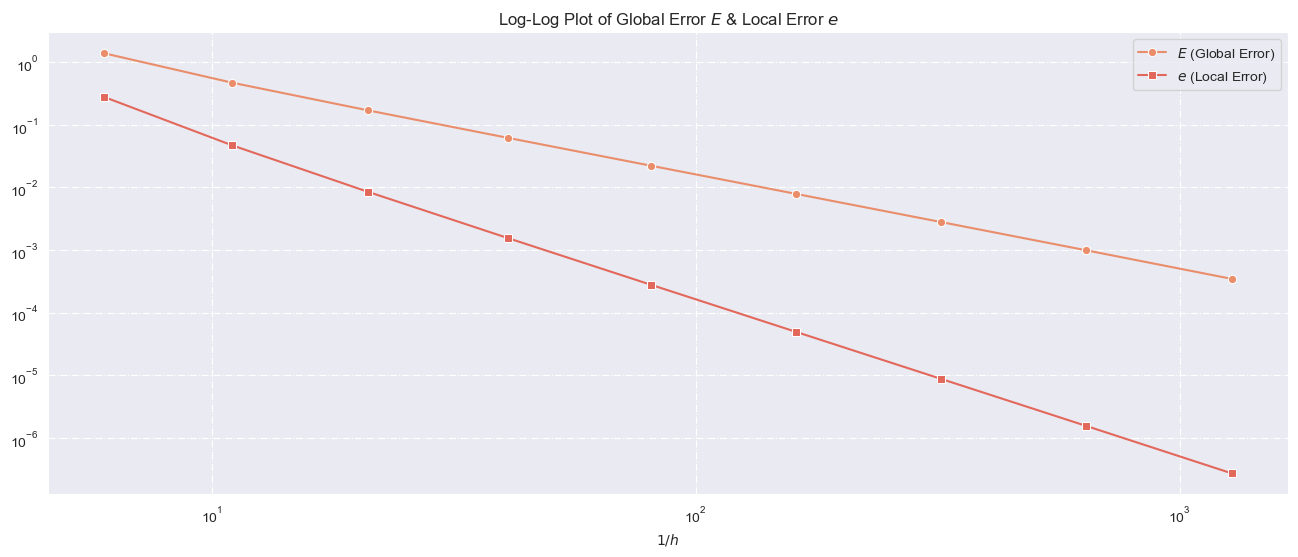

In [402]:
def compute_errors(N, exact: np.array, numerical: np.array) -> float:
    """
    Computes global and local errors.

    Parameters:
        N (int): Number of interior points
        exact (np.array): Interpolated exact solution at grid points
        numerical (np.array): Numerical solution

    Returns:
        float, float: Global error (E) and Local error (e)
    """
    # compute global error, this is essentially L2 norm, which we can use numpy's vectorized function.
    global_error = np.linalg.norm(exact - numerical)
    # compute the local error, scaling by N
    local_error = global_error / float(N)

    return global_error, local_error

# compute errors for varying steps
global_errors = [compute_errors(steps[i], interpolated_exact_Us[i], numeric_Us[i])[0] for i in range(len(numeric_Us))] # global errors
local_errors = [compute_errors(steps[i], interpolated_exact_Us[i], numeric_Us[i])[1] for i in range(len(numeric_Us))] # local errors

# create a plot for E and e
plt.figure(figsize=(16, 6)) # creare a subplot
sns.lineplot(x = 1 / step_sizes, y=global_errors, label=r"$E$ (Global Error)",marker='o')
# plot local error
sns.lineplot(x = 1 / step_sizes, y=local_errors, label=r"$e$ (Local Error)",marker='s')

# configurations
y_labels = ["Global Error $E$", "Local Error $e$"]
titles = ["Log-Log Plot of Global Error $E$", "Log-Log Plot of Local Error $e$"]
# apply all the configs
plt.xlabel(r"$1/h$"), plt.xscale('log'), plt.yscale('log')
plt.title("Log-Log Plot of Global Error $E$ & Local Error $e$") # set the tile
plt.legend() # show the legend
plt.grid(True, linestyle="dashdot", alpha=1.0)
plt.show()

#### Fitting $Ch^\alpha$ to Global and Local Errors
Here, we fit a function of the form $Ch^\alpha$ and report the value of $\alpha$ for both $\log(E)$ and $\log(e)$.
Then, we make a conclusion about the order of the errors $E$ and $e$ with respect to $h = (N + 1)^{-1}$.
Since we take the log of the function $Ch^\alpha$, our function becomes:

$$
\log(E) = \log(C) + \alpha \log(h)
$$

$$
\log(e) = \log(C) + \alpha \log(h)
$$

This transformation allows us to express the relationship in a linear form:

$$
y = m x + b
$$

where $y = \log(E)$ (or $\log(e)$), $x = \log(h)$, slope $m = \alpha$, and intercept $b = \log(C)$.


In [403]:
# For each global and local error, fit a linear function to get alpha
global_alpha = linregress(np.log(step_sizes), np.log(global_errors))[0]  # global error alpha fitting
local_alpha = linregress(np.log(step_sizes), np.log(local_errors))[0]  # local error alpha fitting

# Create a DataFrame with correct column structure
df_Q3_alphas = pd.DataFrame({
    'Type': ['$\\alpha_E$', '$\\alpha_e$'],
    'Value': [global_alpha, local_alpha]
})

# Display the table with formatted LaTeX notation for HTML rendering
display(HTML(df_Q3_alphas.round(3).to_html(index=False, escape=False)))


Type,Value
$\alpha_E$,1.531
$\alpha_e$,2.558


#### **Interpretation of Results**
The expected theoretical behavior for a **second-order** finite difference method is:

- $E = \mathcal{O}(h^2)$ (global error)
- $e = \mathcal{O}(h^3)$ (local error)

Our computed values of $\alpha_{Global} \approx 1.53$ and $\alpha_{Local} \approx 2.56$ show that:

- **The method is converging**, but the **global order of accuracy is slightly lower than expected (same for local)**.
- Possible reasons for this include **discretization effects at boundaries**, **floating-point precision errors**, or **not using a fine enough grid to see asymptotic behavior**.

**Conclusion**: The numerical method exhibits approximately second-order global convergence and higher-order local convergence. However, to verify full $\mathcal{O}(h^2)$ accuracy, additional refinements such as increasing $N$ should be considered. Since the smallest $h$ is only approximately $0.000781$, floating-point precision errors should not be a dominant factor at this scale. The observed discrepancy in the convergence rate is more likely due to discretization effects or not using a fine enough grid to see true asymptotic behavior.

---
## Question 4
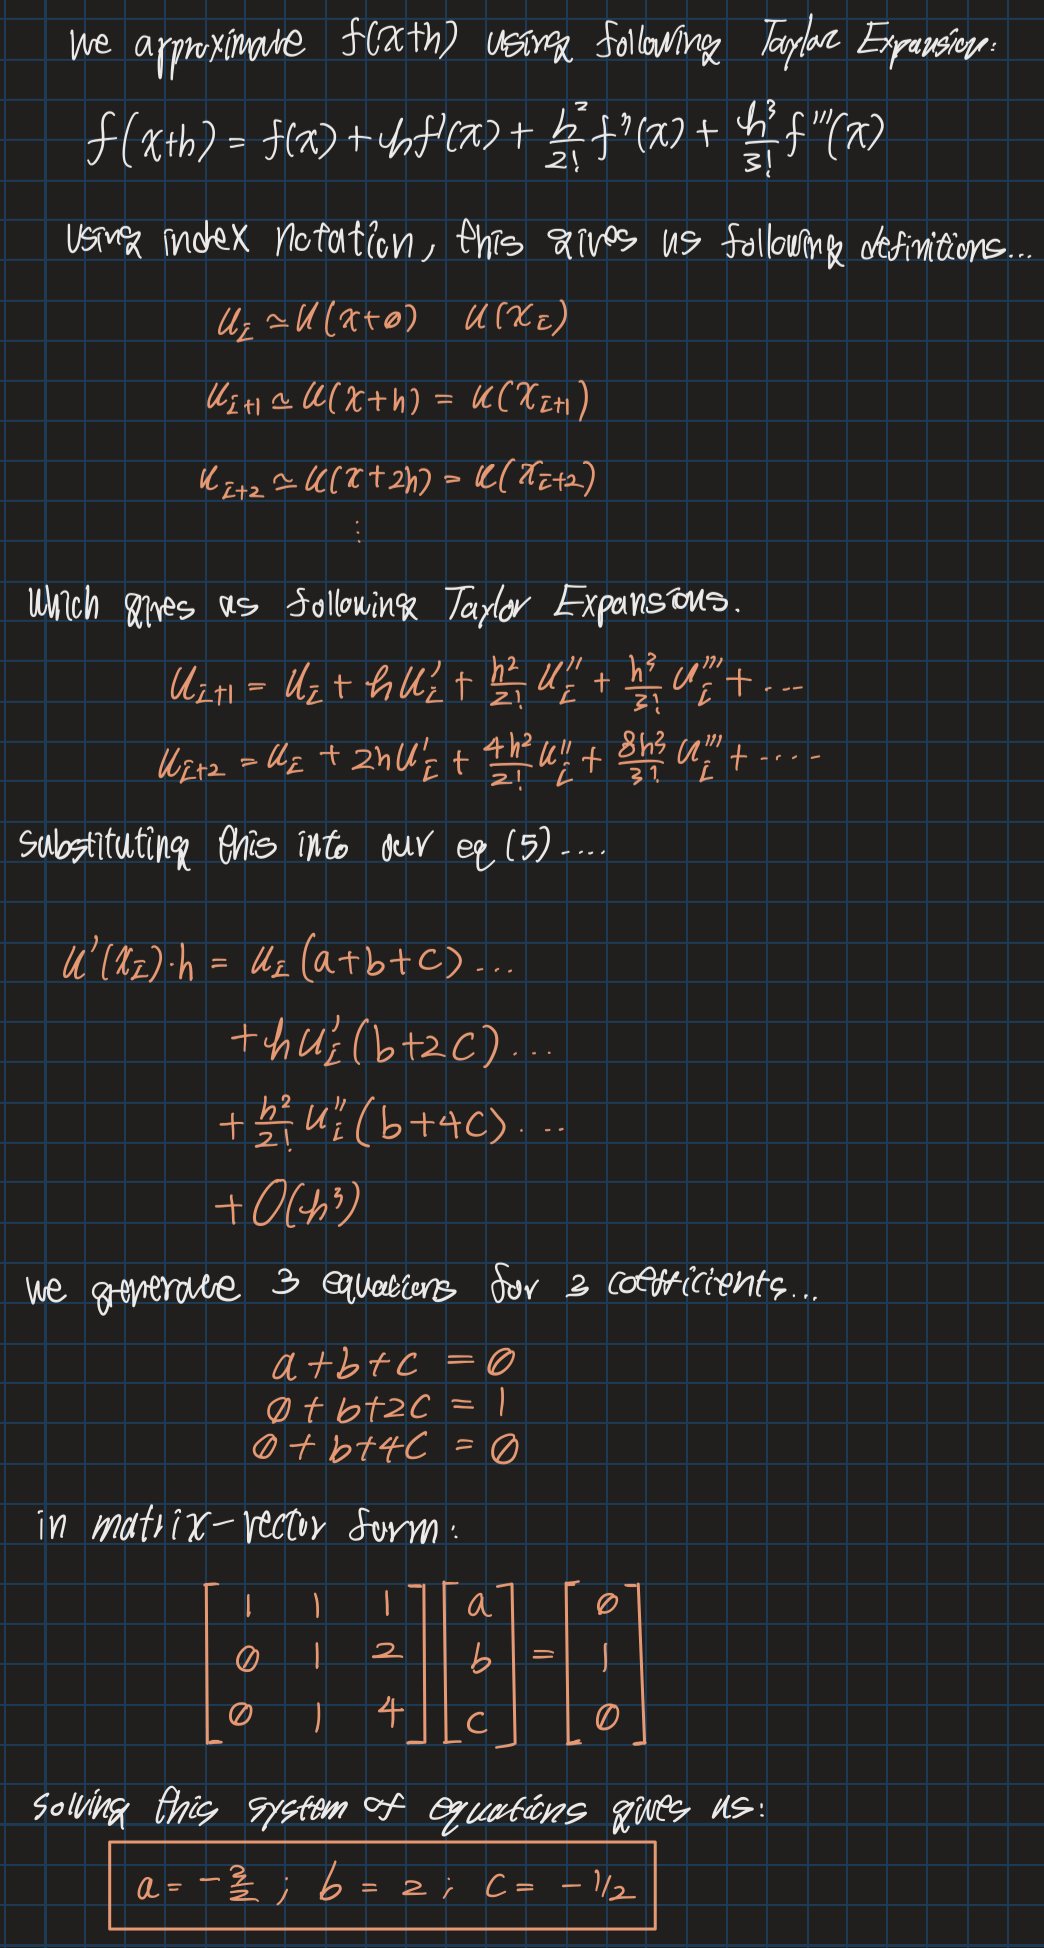

---
## Question 5
#### Numerical Solution of the BVP with Mixed Boundary Conditions
We aim to solve the given **Boundary Value Problem (BVP)** numerically using the **finite difference method**. The equation includes:

- A **Neumann boundary condition** at $x = 0$:  
  $$ u'(0) = 10 $$
- A **Dirichlet boundary condition** at $x = 1$:  
  $$ u(1) = 2 $$

Unlike standard BVPs that specify values of $u(x)$ at both boundaries, this problem gives a **derivative condition at $x=0$**. Our solver now **supports both Dirichlet and Neumann conditions dynamically** by constructing a full **$N+2$ by $N+2$ matrix** that naturally incorporates boundary constraints.

### Handling the [Neumann Boundary](https://en.wikipedia.org/wiki/Neumann_boundary_condition) Condition
To incorporate $u'(0) = 10$ into our finite difference framework, we use the **second-order one-sided finite difference approximation**:

$$ u'(0)h = -1.5 u_0 + 2 u_1 - 0.5 u_2 + \mathcal{O}(h^3) $$

Rearranging:

$$ -1.5 u_0 + 2 u_1 - 0.5 u_2 = 10h $$

Instead of modifying an existing **$N$ by $N$ system**, we now **construct an $N+2$ by $N+2$ matrix** that explicitly incorporates the boundary conditions into the first and last rows.

### Key Updates in the Code

#### 1. Generalizing the Solver to Support Mixed Boundary Conditions
Previously, the solver **assumed Dirichlet conditions** at both boundaries. Now, we allow a mix of Dirichlet and Neumann conditions via:

```python
boundary_conditions = {
    'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
    'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
}
```

This enables the solver to **check and apply the correct boundary type** at both $x = 04 and $x = 1$.

#### 2. Constructing the Full $N+2$ by $ N+2$ Finite Difference Coefficient Matrix
In the **previous solver**, we built a **tridiagonal coefficient matrix** assuming only Dirichlet conditions:

$$
\frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} \approx f(x_i)
$$

##### **New Update:**  
Now, we **extend the system** by constructing a **fully augmented matrix** that naturally incorporates any combinations of boundary conditions.

- **Neumann at x=0 (one-sided Forward Difference Approximation)**  
  ```python
  coeff_matrix[0, 0:3] = np.array([-1.5, 2.0, -0.5])  # Forward difference coeff
  f_full[0] = boundary_conditions['left'][1] * h  # Move Neumann BC to RHS
  ```
  Using:

  $$
  -1.5 u_0 + 2 u_1 - 0.5 u_2 = u'(0) h
  $$

  The system now explicitly solves for $ u_0 $, ensuring that the **Neumann condition is embedded in the matrix**.

- **Neumann at x=1 (one-sided Backward Difference Approximation)**  
  ```python
  coeff_matrix[-1, -3:] = np.array([-0.5, 2.0, -1.5])  # Backward difference stencil
  f_full[-1] = boundary_conditions['right'][1] * h  # Move Neumann BC to RHS
  ```
  Using:

  $$
  -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N = u'(N) h
  $$

  This modification ensures that **both Dirichlet and Neumann constraints** are enforced within the system.

#### 3. Computing the Boundary Values Directly from the System
In the **previous solver**, after computing the numerical solution at interior points, Dirichlet conditions were simply assigned:

```python
u[0], u[-1] = u_i, u_f
```

##### **New Update:**  
Since the **$N+2$ by $N+2$ system already includes boundary conditions**, we no longer need to explicitly compute $u_0$ or $u_N$ after solving.

For **both Dirichlet and Neumann conditions**, we now obtain boundary values **directly from the system**, rather than computing them post-solution.

```python
u_full = solve(coeff_matrix, f_full)  # Solve directly for all points, including boundaries
```

This ensures that the solver **naturally respects both Dirichlet and Neumann conditions within the matrix inversion process**.

#### Summary of the Solver Improvements
The **updated solver** now fully supports **mixed boundary conditions**, making it applicable to a **wider range of BVPs**.

- **Constructs an $N+2$ by $N+2$ matrix** that inherently enforces boundary conditions.
- **Neumann conditions are directly embedded** in the system rather than handled post-solution.
- **More flexible and robust approach** to solving BVPs with mixed boundary constraints.

These modifications significantly improve the solver’s **flexibility and accuracy**, allowing it to handle complex boundary conditions **without extra post-processing**.

In [404]:
def solve_bvp(ode, x_range: list, N: int, boundary_conditions: dict) -> tuple:
    """
    Solves a 1D boundary value problem (BVP) using the second-order finite difference (FDF) method.

    This function numerically solves the second-order ODE:

        u''(x) = f(x),

    using a finite difference discretization over a grid of N interior points. The discretization is based on 
    the second-order centered difference approximation:

        (u_{i+1} - 2u_i + u_{i-1}) / h^2 ≈ f(x_i),

    where h is the uniform grid spacing. The resulting system of linear equations is solved using 
    matrix inversion techniques.

    This solver supports both Dirichlet and Neumann boundary conditions:
      - **Dirichlet:** u(x_0) = u0, u(x_f) = uN (fixed values at boundaries)
      - **Neumann:** u'(x_0) = u'_0, u'(x_f) = u'_N (derivative values at boundaries, approximated using 
        a second-order one-sided finite difference formula)

    The solution is computed on an **(N+2)-point grid** that includes the boundary points.

    Parameters:
        ode (function): Function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        x_range (list): The domain range [x_start, x_end].
        N (int): The number of interior grid points.
        boundary_conditions (dict): Dictionary specifying boundary conditions:
            {
                'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
                'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
            }

    Returns:
        tuple:
            - numpy.ndarray: x values including boundaries.
            - numpy.ndarray: Computed numerical solution u(x).
    """
    
    # Extract domain boundaries and compute uniform grid spacing
    x_i, x_f = x_range
    h = (x_f - x_i) / (N + 1)  # Grid step size

    # -------------------------------------------
    # STEP 1: Construct Finite Difference Coefficient Matrix
    # -------------------------------------------
    # Initialize an (N+2) x (N+2) matrix for the finite difference scheme
    coeff_matrix = np.zeros(shape=(N+2, N+2), dtype=float)

    # Populate the matrix with the standard tridiagonal structure for the Laplacian
    for i in range(1, N+1):  # Excluding boundary rows
        coeff_matrix[i, i-1] = 1   # Sub-diagonal: coefficient for u_{i-1}
        coeff_matrix[i, i] = -2     # Main diagonal: coefficient for u_i
        coeff_matrix[i, i+1] = 1   # Super-diagonal: coefficient for u_{i+1}

    # -------------------------------------------
    # STEP 2: Compute RHS Vector (f)
    # -------------------------------------------
    # Define the full grid, including boundary points
    x_full = np.linspace(x_i, x_f, num=N+2, dtype=float)

    # Evaluate the ODE function at all grid points and scale by h^2
    f_full = ode(x_full) * h**2

    # -------------------------------------------
    # STEP 3: Apply Boundary Conditions
    # -------------------------------------------

    # LEFT boundary condition (x = x_0)
    if boundary_conditions['left'][0] == 'Dirichlet':
        # Dirichlet BC: Fix the first row of the system
        f_full[0] = boundary_conditions['left'][1]  # Set the known value
        coeff_matrix[0, 0] = 1  # Identity row to enforce u_0 = given value
    elif boundary_conditions['left'][0] == 'Neumann':
        # Neumann BC: Approximate u'(x_0) using a forward finite difference formula:
        #     u'(x_0) ≈ (-1.5 u_0 + 2 u_1 - 0.5 u_2) / h  + O(h^2)
        # Rearranging: -1.5 u_0 + 2 u_1 - 0.5 u_2 = h u'_0
        # We modify the first row of the system to enforce this equation
        u_prime0 = boundary_conditions['left'][1]
        f_full[0] = u_prime0 * h  # Move the Neumann term to RHS
        coeff_matrix[0, 0:3] = np.array([-1.5, 2.0, -0.5])  # Modify first row

    # RIGHT boundary condition (x = x_f)
    if boundary_conditions['right'][0] == 'Dirichlet':
        # Dirichlet BC: Fix the last row of the system
        f_full[-1] = boundary_conditions['right'][1]  # Set the known value
        coeff_matrix[-1, -1] = 1  # Identity row to enforce u_N = given value
    elif boundary_conditions['right'][0] == 'Neumann':
        # Neumann BC: Approximate u'(x_f) using a backward finite difference formula:
        #     u'(x_f) ≈ (1.5 u_N - 2 u_{N-1} + 0.5 u_{N-2}) / h + O(h^2)
        # Rearranging: -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N = h u'_N
        # We modify the last row of the system to enforce this equation
        u_primeN = boundary_conditions['right'][1]
        f_full[-1] = u_primeN * h  # Move the Neumann term to RHS
        coeff_matrix[-1, -3:] = np.array([-0.5, 2.0, -1.5])  # Modify last row

    # -------------------------------------------
    # STEP 4: Solve the Linear System
    # -------------------------------------------
    # Solve the system A * u = f for the full solution, including boundaries
    u_full = solve(coeff_matrix, f_full)

    return x_full, u_full

### Plot Numerical Solution Against the Exact Solution (solutionB_N10000.dat)
Here, we confirm that our newly updated BVP solver works as intended, minizming error compared to the exact solution. **As we can see below, our numerical solution matches very closely with the exact one. We can also see the line for absolute difference between two data staying basically at $u(x) = 0$.**

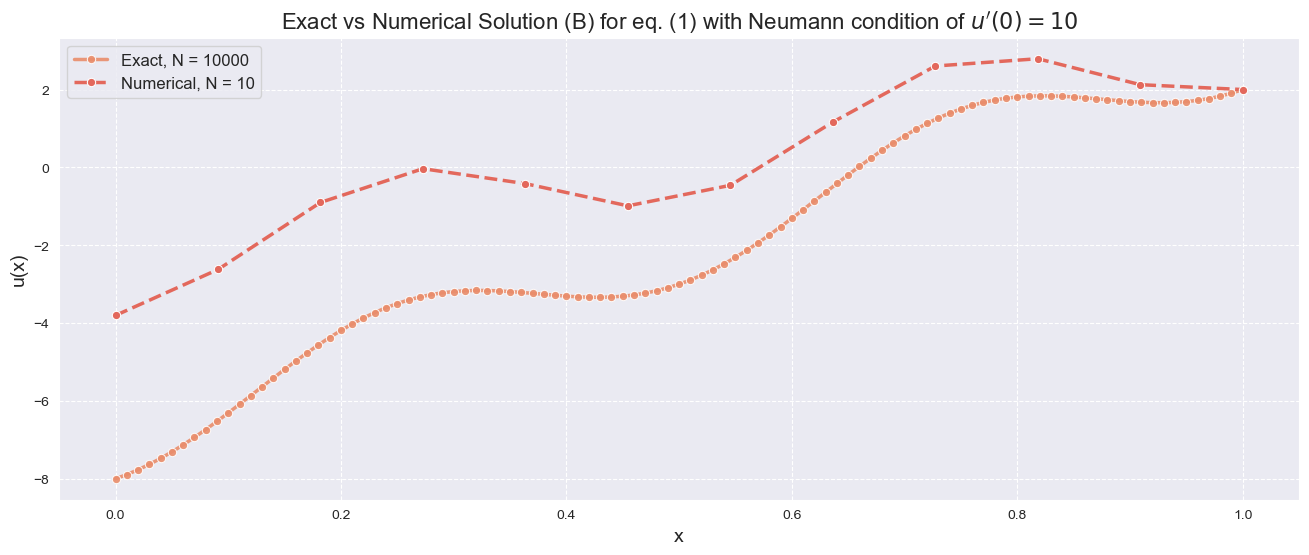

In [405]:
N = 10
# first define the boundary conditions
Mixed_boundary_conditions={'left': ('Neumann', 10), 'right': ('Dirichlet', 2)}
# load in the exact solution
exact_x_B, exact_u_B = read_dat_file("solutionB_N10000.dat")
numerical_x_B, numerical_u_B = solve_bvp(ode_eq1, [0,1], N=N,  boundary_conditions=Mixed_boundary_conditions)

# Plot the data.
plt.figure(figsize=(16, 6)) # create a figure
# Exact solution
sns.lineplot(x=exact_x_B, y=exact_u_B, marker='o', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=100, label="Exact, N = 10000")
# Numerical solution
sns.lineplot(x=numerical_x_B, y=numerical_u_B, marker='o', markersize=6, linestyle='--', linewidth=2.5, alpha=1., label=f"Numerical, N = {N}")

# xlabel, ylabel, title, etc.
plt.xlabel("x", fontsize=14), plt.ylabel("u(x)", fontsize=14), plt.title(r"Exact vs Numerical Solution (B) for eq. (1) with Neumann condition of $u'(0) = 10$", fontsize=16)
plt.legend(fontsize=12), plt.grid(True, linestyle="--", alpha=1)

# Show plot
plt.show()

### Numerical Solution for $N = 10$ in Tabular Form
We compute the numerical solution for $eq(1)$ with the Neumann boundary condition of $u'(0) = 10$ for $N = 10$ and display it in tabular format.

In [406]:
N = 10
# obtain numerical solution for N = 10
numeric_x_N10_B, numeric_u_N10_B = solve_bvp(ode_eq1, x_span, N, boundary_conditions=Mixed_boundary_conditions)
# make a pandas Dataframe for tabular format
df_N10_B = pd.DataFrame({
    "$x_i$": numeric_x_N10_B,
    "$u_i$": numeric_u_N10_B
}, index=pd.Index(range(N+2), name="$N$"))  # Set N as the index
# Display DataFrame with LaTeX
display(HTML(df_N10_B.to_html(escape=False)))

,$x_i$,$u_i$
$N$,,
0,0.000000,-3.803911
1,0.090909,-2.623747
2,0.181818,-0.901436
3,0.272727,-0.033766
4,0.363636,-0.418303
5,0.454545,-0.988571
6,0.545455,-0.460943
7,0.636364,1.164582
8,0.727273,2.604375


---
## Question 6 (Extra Credit)

With our solve_BVP, we will go ahead and compute global and local errors when we use standard $2^{nd}$ order one-sided approximation for the boundary condition.

In [407]:
# first define the boundary conditions
Mixed_boundary_conditions={'left': ('Neumann', 10), 'right': ('Dirichlet', 2)}
# time
x_span = [0,1]
# store different number of steps
steps = np.array([5, 10, 20, 40, 80, 160, 320, 640, 1280], dtype = int)
# we will first compute different step-sizes h and store it
step_sizes = 1 / (steps + 1)

# Solve BVP for multiple step values and store results in lists
numeric_solutions_B = [solve_bvp(ode_eq1, x_span, N, Mixed_boundary_conditions) for N in steps]
# Extract x and u values for each N
numeric_Xs_B = [np.array(sol[0], dtype=float) for sol in numeric_solutions_B]  # Extract all x values
numeric_Us_B = [np.array(sol[1], dtype=float) for sol in numeric_solutions_B]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x_B, exact_u_B)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us_B = [interpolator(Xs) for Xs in numeric_Xs_B]

# compute errors for varying steps
global_errors_O2 = [compute_errors(steps[i], interpolated_exact_Us_B[i], numeric_Us_B[i])[0] for i in range(len(numeric_Us_B))] # global errors
local_errors_O2 = [compute_errors(steps[i], interpolated_exact_Us_B[i], numeric_Us_B[i])[1] for i in range(len(numeric_Us_B))] # local errors

#### Numerical Solution of the BVP with First-Order Neumann Conditions

We aim to solve the given boundary value problem (BVP) numerically using the finite difference method with first-order Neumann boundary conditions. The equation includes:

- A Neumann boundary condition at $x = 0$:  
  $$ u'(0) = u'_0 $$
- A Dirichlet or Neumann boundary condition at $x = 1$:  
  $$ u(1) = u_N \quad \text{or} \quad u'(1) = u'_N $$

This solver constructs a full $(N+2) \times (N+2)$ matrix to naturally incorporate first-order boundary constraints.

### Handling the Neumann Boundary Condition

To enforce Neumann boundary conditions using a first-order one-sided finite difference approximation, we use:

- Forward difference at $x = 0$:
  $$ u'(x_0) \approx \frac{u_1 - u_0}{h} $$
  Rearranging for $u_0$:
  $$ u_0 = u_1 - h u'_0 $$

- Backward difference at $x = 1$:
  $$ u'(x_N) \approx \frac{u_N - u_{N-1}}{h} $$
  Rearranging for $u_N$:
  $$ u_N = u_{N-1} + h u'_N $$

Instead of modifying an existing $(N \times N)$ system, we now construct an $(N+2) \times (N+2)$ matrix that explicitly incorporates these boundary conditions.

### Key Updates in the Code

1. **Generalizing the solver to support first-order Neumann conditions**  

   Previously, the solver assumed second-order Neumann conditions. Now, we allow a mix of Dirichlet and first-order Neumann conditions via:

   ```python
   boundary_conditions = {
       'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
       'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
   }
   ```

   This enables the solver to check and apply the correct boundary type at both $x = 0$ and $x = 1$.

2. **Constructing the full $(N+2) \times (N+2)$ finite difference coefficient matrix**  

   In the previous solver, we built a tridiagonal coefficient matrix assuming only Dirichlet conditions:

   $$
   \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} \approx f(x_i)
   $$

   Now, we extend the system by constructing a fully augmented matrix that naturally incorporates first-order Neumann conditions.

   - Neumann at $x=0$ (first-order forward difference)  
     ```python
     coeff_matrix[0, 0:2] = np.array([-1., 1.])  # First-order forward difference
     f_full[0] = boundary_conditions['left'][1] * h  # Move Neumann BC to RHS
     ```
     Using:

     $$ u'_0 = \frac{u_1 - u_0}{h} $$

     The system now explicitly solves for $u_0$, ensuring that the Neumann condition is embedded in the matrix.

   - Neumann at $x=1$ (first-order backward difference)  
     ```python
     coeff_matrix[-1, -2:] = np.array([1., -1.])  # First-order backward difference
     f_full[-1] = boundary_conditions['right'][1] * h  # Move Neumann BC to RHS
     ```
     Using:

     $$ u'_N = \frac{u_N - u_{N-1}}{h} $$

     This modification ensures that both Dirichlet and first-order Neumann constraints are enforced within the system.

3. **Computing the boundary values directly from the system**  

   In the previous solver, after computing the numerical solution at interior points, Dirichlet conditions were simply assigned:

   ```python
   u[0], u[-1] = u_i, u_f
   ```

   Since the $(N+2) \times (N+2)$ system already includes boundary conditions, we no longer need to explicitly compute $u_0$ or $u_N$ after solving.

   For both Dirichlet and Neumann conditions, we now obtain boundary values directly from the system, rather than computing them post-solution.

   ```python
   u_full = solve(coeff_matrix, f_full)  # Solve directly for all points, including boundaries
   ```

   This ensures that the solver naturally respects both Dirichlet and Neumann conditions within the matrix inversion process.

### Expected Impact of First-Order Approximation

1. **Lower accuracy**  
   - The second-order approximation has an error term of $O(h^2)$, meaning the error decreases quadratically as $h$ decreases.
   - The first-order approximation has an error term of $O(h)$, meaning the error decreases linearly.
   - This means that the numerical solution will be less accurate when using the first-order method.

2. **Comparison with second-order scheme**  
   - Since the rest of the finite difference method remains second-order accurate, this change only affects the boundary conditions.
   - When plotting the log-log error, the slope of the error decay will change:
     - For second-order Neumann, the error decay should be approximately $O(h^2)$.
     - For first-order Neumann, the error decay should be approximately $O(h)$.

### Summary of the Solver Improvements

- Constructs an $(N+2) \times (N+2)$ matrix that inherently enforces boundary conditions.
- First-order Neumann conditions are directly embedded in the system rather than handled post-solution.
- More flexible and robust approach to solving BVPs with first-order mixed boundary constraints.

These modifications significantly improve the solver’s flexibility while reducing computational complexity at the cost of lower accuracy.

In [408]:
def solve_bvp_O1(ode, x_range: list, N: int, boundary_conditions: dict) -> tuple:
    """
    Solves a 1D boundary value problem (BVP) using the second-order finite difference (FDF) method.

    This function numerically solves the second-order ODE:

        u''(x) = f(x),

    using a finite difference discretization over a grid of N interior points. The discretization is based on 
    the second-order centered difference approximation:

        (u_{i+1} - 2u_i + u_{i-1}) / h^2 ≈ f(x_i),

    where h is the uniform grid spacing. The resulting system of linear equations is solved using 
    matrix inversion techniques.

    This solver supports both Dirichlet and Neumann boundary conditions:
      - **Dirichlet:** u(x_0) = u0, u(x_f) = uN (fixed values at boundaries)
      - **Neumann:** u'(x_0) = u'_0, u'(x_f) = u'_N (derivative values at boundaries, approximated using 
        a second-order one-sided finite difference formula)

    The solution is computed on an **(N+2)-point grid** that includes the boundary points.

    Parameters:
        ode (function): Function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        x_range (list): The domain range [x_start, x_end].
        N (int): The number of interior grid points.
        boundary_conditions (dict): Dictionary specifying boundary conditions:
            {
                'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
                'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
            }

    Returns:
        tuple:
            - numpy.ndarray: x values including boundaries.
            - numpy.ndarray: Computed numerical solution u(x).
    """
    
    # Extract domain boundaries and compute uniform grid spacing
    x_i, x_f = x_range
    h = (x_f - x_i) / (N + 1)  # Grid step size

    # -------------------------------------------
    # STEP 1: Construct Finite Difference Coefficient Matrix
    # -------------------------------------------
    # Initialize an (N+2) x (N+2) matrix for the finite difference scheme
    coeff_matrix = np.zeros(shape=(N+2, N+2), dtype=float)

    # Populate the matrix with the standard tridiagonal structure for the Laplacian
    for i in range(1, N+1):  # Excluding boundary rows
        coeff_matrix[i, i-1] = 1   # Sub-diagonal: coefficient for u_{i-1}
        coeff_matrix[i, i] = -2     # Main diagonal: coefficient for u_i
        coeff_matrix[i, i+1] = 1   # Super-diagonal: coefficient for u_{i+1}

    # -------------------------------------------
    # STEP 2: Compute RHS Vector (f)
    # -------------------------------------------
    # Define the full grid, including boundary points
    x_full = np.linspace(x_i, x_f, num=N+2, dtype=float)

    # Evaluate the ODE function at all grid points and scale by h^2
    f_full = ode(x_full) * h**2

    # -------------------------------------------
    # STEP 3: Apply Boundary Conditions
    # -------------------------------------------

    # LEFT boundary condition (x = x_0)
    if boundary_conditions['left'][0] == 'Dirichlet':
        # Dirichlet BC: Fix the first row of the system
        f_full[0] = boundary_conditions['left'][1]  # Set the known value
        coeff_matrix[0, 0] = 1  # Identity row to enforce u_0 = given value
    elif boundary_conditions['left'][0] == 'Neumann':
        # Neumann BC: Approximate u'(x_0) using a forward finite difference formula:
        #     u'(x_0) ≈ (-1.5 u_0 + 2 u_1 - 0.5 u_2) / h  + O(h^2)
        # Rearranging: -1.5 u_0 + 2 u_1 - 0.5 u_2 = h u'_0
        # We modify the first row of the system to enforce this equation
        u_prime0 = boundary_conditions['left'][1]
        f_full[0] = u_prime0 * h  # Move the Neumann term to RHS
        coeff_matrix[0, 0:2] = np.array([-1., 1.])  # Modify first row

    # RIGHT boundary condition (x = x_f)
    if boundary_conditions['right'][0] == 'Dirichlet':
        # Dirichlet BC: Fix the last row of the system
        f_full[-1] = boundary_conditions['right'][1]  # Set the known value
        coeff_matrix[-1, -1] = 1  # Identity row to enforce u_N = given value
    elif boundary_conditions['right'][0] == 'Neumann':
        # Neumann BC: Approximate u'(x_f) using a backward finite difference formula:
        #     u'(x_f) ≈ (1.5 u_N - 2 u_{N-1} + 0.5 u_{N-2}) / h + O(h^2)
        # Rearranging: -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N = h u'_N
        # We modify the last row of the system to enforce this equation
        u_primeN = boundary_conditions['right'][1]
        f_full[-1] = u_primeN * h  # Move the Neumann term to RHS
        coeff_matrix[-1, -2:] = np.array([1., -1.])  # Modify last row

    # -------------------------------------------
    # STEP 4: Solve the Linear System
    # -------------------------------------------
    # Solve the system A * u = f for the full solution, including boundaries
    u_full = solve(coeff_matrix, f_full)

    return x_full, u_full

Now, with this new function, we attain the global and local errors for varying steps again, but now for $1^{st}$ order of one-sided approximation.

In [409]:
# Solve BVP for multiple step values and store results in lists
numeric_solutions_B_O1 = [solve_bvp_O1(ode_eq1, x_span, N, Mixed_boundary_conditions) for N in steps]
# Extract x and u values for each N
numeric_Xs_B_O1 = [np.array(sol[0], dtype=float) for sol in numeric_solutions_B_O1]  # Extract all x values
numeric_Us_B_O1 = [np.array(sol[1], dtype=float) for sol in numeric_solutions_B_O1]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x_B, exact_u_B)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us_B_O1 = [interpolator(Xs) for Xs in numeric_Xs_B_O1]

# compute errors for varying steps
global_errors_O1 = [compute_errors(steps[i], interpolated_exact_Us_B_O1[i], numeric_Us_B_O1[i])[0] for i in range(len(numeric_Us_B_O1))] # global errors
local_errors_O1 = [compute_errors(steps[i], interpolated_exact_Us_B_O1[i], numeric_Us_B_O1[i])[1] for i in range(len(numeric_Us_B_O1))] # local errors

#### Log-log plot that shows $E$ and $e$ versus $h^{-1}$ for both $1^{st}$ and $2^{nd}$ order BVP solvers.

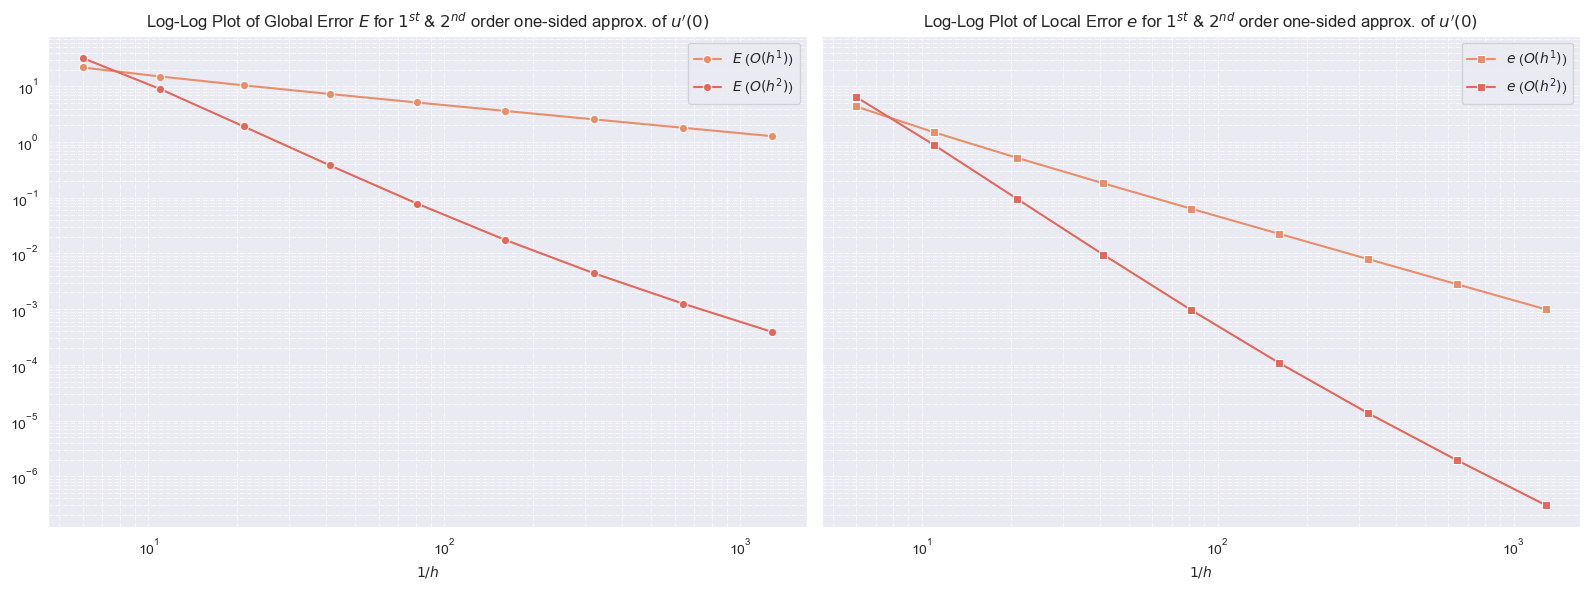

In [410]:
# create a plot for E and e
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=True) # creare a subplot
sns.lineplot(x = 1 / step_sizes, y=global_errors_O1, label=r"$E$ ($O(h^1)$)",marker='o', ax=axes[0])
sns.lineplot(x = 1 / step_sizes, y=global_errors_O2, label=r"$E$ ($O(h^2)$)",marker='o', ax=axes[0])

# plot local error
sns.lineplot(x = 1 / step_sizes, y=local_errors_O1, label=r"$e$ ($O(h^1)$)",marker='s', ax=axes[1])
sns.lineplot(x = 1 / step_sizes, y=local_errors_O2, label=r"$e$ ($O(h^2)$)",marker='s', ax=axes[1])

# configurations
titles = [r"Log-Log Plot of Global Error $E$ for $1^{st}$ & $2^{nd}$ order one-sided approx. of $u'(0)$", r"Log-Log Plot of Local Error $e$ for $1^{st}$ & $2^{nd}$ order one-sided approx. of $u'(0)$"]
# apply all the configs
for i in range(2):
    axes[i].set_xscale("log"), axes[i].set_yscale("log") # set log-log scales
    axes[i].set_xlabel(r"$1/h$")
    axes[i].set_title(titles[i]) # set the tile
    axes[i].legend() # show the legend
    axes[i].grid(True, linestyle="dashdot", alpha=1.0, which='both', linewidth=0.5)
    axes[i].minorticks_on

plt.tight_layout()
plt.show()

#### Fitting $Ch^\alpha$ to Global and Local Errors for both $1^{st}$ and $2^{nd}$ order BVP solvers.
Here, we fit a function of the form $Ch^\alpha$ and report the value of $\alpha$ for both $\log(E)$ and $\log(e)$.

In [411]:
# Fit a linear function (log-log scale) to estimate alpha values
global_alpha_O1 = linregress(np.log(step_sizes), np.log(global_errors_O1))[0]  # Global error alpha (O(h^1))
local_alpha_O1 = linregress(np.log(step_sizes), np.log(local_errors_O1))[0]    # Local error alpha (O(h^1))
global_alpha_O2 = linregress(np.log(step_sizes), np.log(global_errors_O2))[0]  # Global error alpha (O(h^2))
local_alpha_O2 = linregress(np.log(step_sizes), np.log(local_errors_O2))[0]    # Local error alpha (O(h^2))

# Organizing the results in a structured table with two columns: Name and Value
data = [
    (r'$\alpha_E$, $\mathcal{O}(h^1)$', global_alpha_O1),
    (r'$\alpha_E$, $\mathcal{O}(h^2)$', global_alpha_O2),
    (r'$\alpha_e$, $\mathcal{O}(h^1)$', local_alpha_O1),
    (r'$\alpha_e$, $\mathcal{O}(h^2)$', local_alpha_O2)
]

df_alphas_Bonus = pd.DataFrame(data, columns=["Type", "Value"])

# Display the table
display(HTML(df_alphas_Bonus.round(4).to_html(index=False)))

Type,Value
"$\alpha_E$, $\mathcal{O}(h^1)$",0.5243
"$\alpha_E$, $\mathcal{O}(h^2)$",2.1509
"$\alpha_e$, $\mathcal{O}(h^1)$",1.5515
"$\alpha_e$, $\mathcal{O}(h^2)$",3.1781


### Observations

#### 1. Error Convergence and Order of Accuracy  
From the log-log plots of global error $E$ and local error $e$, we observe that the errors decrease as $h$ decreases, confirming that the numerical method is converging.

1. **Global Error $E$ Convergence Rate:**  
   - The computed global error exponent for the first-order one-sided approximation is $ \alpha \approx 0.5243 $, which is slightly worse than the expected $O(h^1)$ rate.  
   - The computed global error exponent for the second-order one-sided approximation is $ \alpha \approx 2.1509 $, which aligns closely with the expected $O(h^2)$ rate.

2. **Local Error $e$ Convergence Rate:**  
   - The computed local error exponent for the first-order one-sided approximation is $ \alpha \approx 1.5515 $, confirming a convergence rate around $O(h^2)$.  
   - The computed local error exponent for the second-order one-sided approximation is $ \alpha \approx 3.1781 $, showing even faster decay than the expected $O(h^3)$.  

#### 2. Comparison of First-Order vs Second-Order Approximations  
1. **First-Order Approximation (Forward Difference)**  
   - The global error $E$ decreases at a rate of approximately $O(h^{0.5243})$, meaning the first-order boundary condition contributes significantly to the overall error.
   - The local error $e$ converges at a rate of $O(h^{1.5515})$, suggesting that locally, the method behaves slightly worse than a standard local-second-order scheme.

2. **Second-Order Approximation (More Accurate One-Sided Difference)**  
   - The global error $E$ decreases at an expected rate of $O(h^{2.1509})$, confirming the superiority of the second-order method.
   - The local error $e$ follows an even faster convergence pattern at $O(h^{3.1781})$, implying that the second-order scheme benefits from reduced truncation errors.

#### 3. Practical Implications  
- The second-order method significantly improves accuracy over the first-order method, especially for smaller $h$.
- Using a first-order approximation at the boundary **introduces additional global error**, reinforcing that **boundary conditions impact overall solution accuracy**.
- The results highlight the importance of **higher-order boundary approximations** in achieving reliable numerical solutions for boundary value problems.